In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
txs = pd.read_pickle('../../data/transactions-v4.pkl')

In [32]:
# Display all the columns
print(txs.columns)


Index(['inputs_hash', 'tx_id', 'found_at', 'mined_at', 'pruned_at',
       'child_txid', 'absolute_fee', 'fee_rate', 'version', 'waittime',
       'rbf_fee_total', 'mempool_size', 'mempool_tx_count', 'weight', 'size'],
      dtype='object')


In [33]:
# Simple questions to ensure our data is sane before we start building models

# 1. How many transactions are in the dataset?
print(f"Number of transactions: {len(txs)}")

# 2. What is the average wait time?
avg_waittime = txs['waittime'].mean()
print(f"Average wait time: {int(avg_waittime)} seconds, {int(avg_waittime/60)} minutes")

# Median wait time
median_waittime = txs['waittime'].median()
print(f"Median wait time: {int(median_waittime)} seconds, {int(median_waittime/60)} minutes")

# 3. What is the average mempool size?
avg_mempool_size = txs['mempool_size'].mean()
print(f"Average mempool size: {int(avg_mempool_size)}")

# 4. time window for txs
min_found_at = pd.to_datetime(txs['found_at'].min(), unit='s')
max_found_at = pd.to_datetime(txs['found_at'].max(), unit='s')
print(f"Time window for txs: {min_found_at} to {max_found_at}")


Number of transactions: 5206
Average wait time: 4090 seconds, 68 minutes
Median wait time: 1776 seconds, 29 minutes
Average mempool size: 15879255
Time window for txs: 2025-05-16 06:55:46 to 2025-05-17 18:58:59


In [38]:
txs['weight'].describe()

count     5206.000000
mean       645.495966
std       1313.296727
min        328.000000
25%        340.000000
50%        464.000000
75%        632.000000
max      84092.000000
Name: weight, dtype: float64

In [39]:
txs['size'].describe()

count     5206.000000
mean       161.373992
std        328.324182
min         82.000000
25%         85.000000
50%        116.000000
75%        158.000000
max      21023.000000
Name: size, dtype: float64

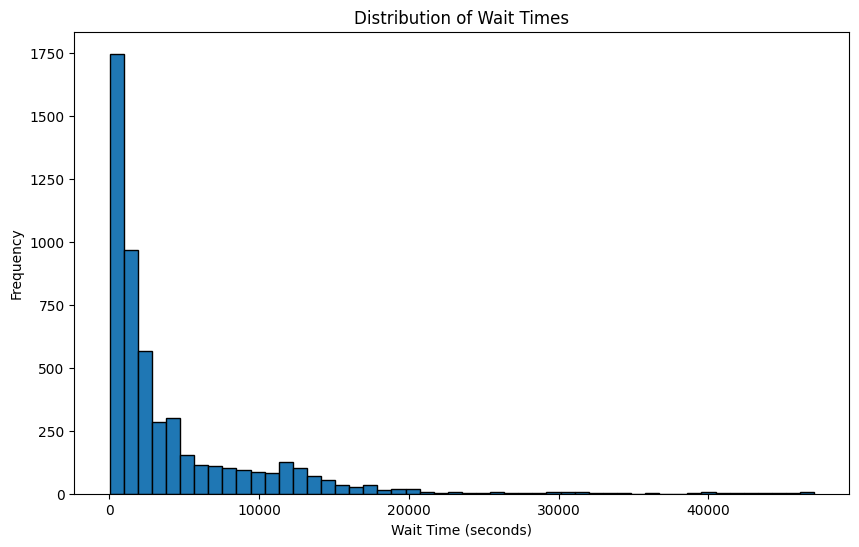

In [35]:
# Plot distribution of wait times
plt.figure(figsize=(10, 6))
plt.hist(txs['waittime'], bins=50, edgecolor='black')
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Plot txs Fee vs Waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['waittime'], txs['absolute_fee'], alpha=0.3)
plt.title('Fee vs Wait Time')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Fee (satoshis)')
plt.show()

In [ ]:
# Plot the distribution of mempool sizes
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_size'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Sizes')
plt.xlabel('Mempool Size')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Plot mempool tx count
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_tx_count'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Tx Counts')
plt.xlabel('Mempool Tx Count')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Plot mempool size vs waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['mempool_tx_count'], txs['waittime'], alpha=0.3)
plt.xlabel('Mempool Tx Count')
plt.ylabel('Wait Time (seconds)')
plt.title('Mempool Tx Count vs Wait Time')
plt.show()

In [22]:
# Lets remove the weird tail of the distribution
txs = txs[txs['mempool_tx_count'] <= 14_000]

In [ ]:
# Compute heat map of mempool tx count vs waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['mempool_tx_count'], txs['waittime'], alpha=0.3)
plt.xlabel('Mempool Tx Count')
plt.ylabel('Wait Time (seconds)')
plt.title('Mempool Tx Count vs Wait Time')
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Standardize features since they're on very different scales
scaler = StandardScaler()
X = txs[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
X_scaled = scaler.fit_transform(X)
y = txs['waittime']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Fit KNN regressor
knn = KNeighborsRegressor(n_neighbors=50, weights='distance')
knn.fit(X_train, y_train)

# Calculate R² scores
train_r2 = knn.score(X_train, y_train)
test_r2 = knn.score(X_test, y_test)
print(f"Train R² = {train_r2:.4f}")
print(f"Test R² = {test_r2:.4f}")

# Plot observed vs predicted
y_pred = knn.predict(X_scaled)
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Observed wait-time (seconds)')
plt.ylabel('Predicted wait-time (seconds)')
plt.title(f'KNN Regression (Train R²={train_r2:.2f}, Test R²={test_r2:.2f})')
plt.grid(True)
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

X = txs[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = txs['waittime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("XGBoost Regression Performance")
plt.show()


In [ ]:
scaler = StandardScaler()
X = txs[['mempool_size', 'absolute_fee']]
X_scaled = scaler.fit_transform(X)
y = txs['waittime']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = LinearRegression().fit(X_train, y_train)

# Calculate R² scores
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R² = {train_r2:.4f}")
print(f"Test R² = {test_r2:.4f}")

# Plot observed vs predicted
y_pred = model.predict(X_scaled)
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Observed wait-time (seconds)')
plt.ylabel('Predicted wait-time (seconds)')
plt.title(f'Linear Regression (Train R²={train_r2:.2f}, Test R²={test_r2:.2f})')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = txs[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = txs['waittime']
# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R^2: {r2:.4f}")

# 6. Optional: Plot predicted vs true
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression Performance")
plt.show()